# オッズの予測精度評価
人気順の上位3位が、実際に3位以内に入る可能性のモデルの精度評価。このスコアを超えない限り、オッズ通りに買った方が有利ということになる。

In [1]:
# Resultモデルをデータフレームに変換
# Getting Data
from umap.uhelper import pd_result
cols = ["rank", "odor"]
df = pd_result(cols, True)

In [2]:
import numpy as np

# 目的変数の作成（3位以内ならFalse（ゼロ）、それ以外はTrue（1））
df["top3"] = np.where(df["rank"]<=3, False, True)
df["odor3"] = np.where(df["odor"]<=3, False, True)

# 不要データの削除
df = df.drop(["rank", "odor"], axis=1)

             precision    recall  f1-score   support

      False       0.52      0.51      0.51     45218
       True       0.87      0.87      0.87    166997

avg / total       0.79      0.79      0.79    212215

複勝馬の的中率（Recall）: 0.508
購入馬券の的中率（Precision）: 0.518


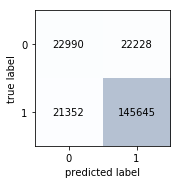

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(df.top3, df.odor3))
tp, fn, fp, tn = confusion_matrix(df.top3, df.odor3).ravel()
print('複勝馬の的中率（Recall）: {:.3f}'.format(tp / (tp + fn)))
print('購入馬券の的中率（Precision）: {:.3f}'.format(tp / (tp + fp)))

# Confusion Matrixを使った精度評価
cnf_matrix = confusion_matrix(df.top3, df.odor3)
fig, ax = plot_confusion_matrix(cnf_matrix)
plt.show()

# Sample Prediction Model Creation

In [4]:
# レース結果（出走結果のあるデータを抽出）
from umap.uhelper import pd_result
cols = ["rank", "sex", "age", "t3r_jockey", "cnt_run", "t3r_horse", "avg_ror", "avg_prize", "avg_last3f", "race__weather", "race__condition", "race__head_count", "race__max_prize", "race__odds_stdev"]
df = pd_result(cols, True)
#df.info()

In [5]:
import numpy as np
import pandas as pd
# 計算列の追加
df["grade_rate"] = round(df.avg_prize / df.race_prize, 2)

# 性別データのダミー変数化
dmy_sex = pd.get_dummies(df.sex)
df = pd.concat([df, dmy_sex], axis=1)
df = df.drop("sex", axis=1)
df = df.rename(columns={"セ": "gelding", "牝": "female", "牡": "male"})

# 馬場データのダミー変数化
dmy_condition = pd.get_dummies(df.condition)
df = pd.concat([df, dmy_condition], axis=1)
df = df.drop("condition", axis=1)
df = df.rename(columns={"不良": "soft", "稍重": "good", "良": "firm", "重": "yielding"})

# 天候データのダミー変数化
dmy_weather = pd.get_dummies(df.weather)
df = pd.concat([df, dmy_weather], axis=1)
df = df.drop("weather", axis=1)
df = df.rename(columns={"晴": "sunny", "曇": "cloudy", "小雨": "l-rainy", "雨": "rainy", "小雪": "snowly", "雪": "l-snowly"})

# 目的変数の作成（3位以内ならゼロ、それ以外は1）
df["top3"] = np.where(df["rank"]<=3, 0, 1)

# 不要データの削除
df = df.drop("rank", axis=1)
df.head()

,age,avg_last3f,avg_prize,avg_ror,cnt_run,head_count,race_prize,odds_stdev,t3r_horse,t3r_jockey,...,good,firm,yielding,l-rainy,snowly,sunny,cloudy,rainy,l-snowly,top3
0,3,41.700,0.000,0.000,3,16,500.0,55.097,0.000,0.06,...,0,1,0,0,0,1,0,0,0,1
1,3,38.575,60.000,5.100,4,16,500.0,55.097,0.250,0.34,...,0,1,0,0,0,1,0,0,0,1
2,3,37.967,96.667,6.967,3,16,500.0,55.097,0.333,0.32,...,0,1,0,0,0,1,0,0,0,1
3,3,38.120,15.000,0.000,7,16,500.0,55.097,0.000,0.18,...,0,1,0,0,0,1,0,0,0,1
4,3,38.200,0.000,0.000,4,16,500.0,55.097,0.000,0.14,...,0,1,0,0,0,1,0,0,0,1


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# データの標準化
sc = StandardScaler()
df_std = sc.fit_transform(df.drop("top3", axis=1))
# データの分割
X = pd.DataFrame(df_std)
y = df.top3
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [7]:
# 学習（時間がかかります）
from sklearn.svm import SVC
from sklearn import linear_model, ensemble
clf = SVC(kernel="rbf", class_weight="balanced")
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

             precision    recall  f1-score   support

          0       0.33      0.67      0.44     11256
          1       0.88      0.64      0.74     41798

avg / total       0.76      0.64      0.68     53054

複勝馬の的中率（Recall）: 0.666
購入馬券の的中率（Precision）: 0.332


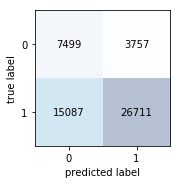

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

y_pred = clf.predict(X_test)
tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()

print(classification_report(y_test, y_pred))
recall = round(tp / (tp + fn), 3)
precision = round(tp / (tp + fp), 3)
print("複勝馬の的中率（Recall）: " + str(recall))
print("購入馬券の的中率（Precision）: " + str(precision))

# Confusion Matrixを使った精度評価
cnf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(cnf_matrix)
plt.show()

In [11]:
# モデルの保存
import pickle

model_name = "svc_v1"

p = Pmodel()
p.title = model_name
p.model_bin = clf
p.method = "classification"
p.columns = cols
p.recall = recall
p.precision = precision
p.note = "class_weight='balanced'"
p.save()

Pmodel.objects.filter(title=model_name).values("title", "method", "recall", "precision", "note")

<QuerySet [{'title': 'svc_v1', 'method': 'classification', 'recall': 0.666, 'precision': 0.332, 'note': "class_weight='balanced'"}]>